## Preprocessing and Statistics

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt  
import wfdb
from tqdm import tqdm
import logging
import pickle
import time
import traceback
import sys  # Import sys module

# Reduce Logging Frequency:
# Log every 10 channels instead of every channel
LOGGING_FREQUENCY = 10

# Log to File:
logging.basicConfig(filename='processing.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the classes we're interested in (now using SNOMED CT codes)
CLASSES_OF_INTEREST = ['426177001', '426783006', '164890007', '427084000',
                       '55930002', '59931005', '164889003', '427393009', '164934002',
                       '429622005', '39732003']

def load_snomed_ct_mapping(csv_path):
    mapping_df = pd.read_csv(csv_path)
    code_to_acronym = dict(zip(mapping_df['Snomed_CT'].astype(str), mapping_df['Acronym Name']))
    code_to_fullname = dict(zip(mapping_df['Snomed_CT'].astype(str), mapping_df['Full Name']))
    return code_to_acronym, code_to_fullname

def extract_clinical_data(header):
    try:
        age = 'Unknown'
        sex = 'Unknown'
        dx_codes = []
        
        for line in header.comments:
            if line.startswith('Age:'):
                age_str = line.split(': ')[1]
                if age_str.isdigit():
                    age = int(age_str)
                elif age_str.lower() == 'nan':
                    age = 'Unknown'
                else:
                    logging.warning(f"Unexpected age value: {age_str}")
            elif line.startswith('Sex:'):
                sex = line.split(': ')[1]
            elif line.startswith('Dx:'):
                dx_codes = line.split(': ')[1].split(',')
        
        return age, sex, dx_codes
    except Exception as e:
        logging.error(f"Error extracting clinical data: {str(e)}")
        return 'Unknown', 'Unknown', []

def load_and_process_ecg(record_name, code_to_acronym, code_to_fullname):
    try:
        logging.info(f"Starting to read record: {record_name}")
        record = wfdb.rdrecord(record_name)
        logging.info(f"Finished reading record: {record_name}")

        header = wfdb.rdheader(record_name)

        print(f"Record n_sig: {record.n_sig}")  # Print number of signals
        print(f"Record p_signal shape: {record.p_signal.shape}")  # Print signal shape
        print(f"Record fs: {record.fs}")  # Print sampling frequency
        print(f"Record sig_len: {record.sig_len}")  # Print signal length
        print(f"Record base_date: {record.base_date}")  # Print base date
        print(f"Record base_time: {record.base_time}")  # Print base time

        signals = record.p_signal.T  # Get the signals directly

        age, sex, dx_codes = extract_clinical_data(header)

        if not dx_codes:
            raise ValueError("Missing or invalid clinical data")

        return signals, age, sex, dx_codes
    except Exception as e:
        logging.error(f"Error processing record {record_name}: {str(e)}")
        logging.error(traceback.format_exc())
        return None, 'Unknown', 'Unknown', []

def find_hea_files(directory):
    for root, dirs, files in os.walk(directory):
        dirs[:] = [d for d in dirs if not d.startswith('.')]
        for file in files:
            if file.endswith('.hea'):
                yield os.path.join(root, file)

def prepare_dataset(data_dir, code_to_acronym, code_to_fullname, num_samples=1000):
    X = []
    y = []
    clinical_data = []
    wfdb_dir = os.path.join(data_dir, 'WFDBRecords')
    
    logging.info(f"Looking for records in: {wfdb_dir}")
    if not os.path.exists(wfdb_dir):
        logging.error(f"Directory does not exist: {wfdb_dir}")
        return np.array(X), y, pd.DataFrame(clinical_data), {}

    total_processed = 0
    total_errors = 0
    diagnoses_count = {}
    excluded_samples = 0
    nan_records = []

    total_files = sum(1 for _ in find_hea_files(wfdb_dir))
    
    with tqdm(total=total_files + 3, desc="Processing", unit="item") as pbar:  # Total items: files + 3 saving steps
        for hea_file in find_hea_files(wfdb_dir):
            print(f"Processing file: {hea_file}")  # Print the filename
            start_time = time.time()  # Start timing the file processing
            try:
                mat_file = hea_file[:-3] + 'mat'  # Construct the .mat file name
                file_size_mb = os.path.getsize(mat_file) / (1024 * 1024)  # Get .mat file size in MB
                logging.info(f"Processing file: {hea_file} (Size: {file_size_mb:.2f} MB)")

                total_processed += 1
                record_name = hea_file[:-4]
                signals, age, sex, dx_codes = load_and_process_ecg(record_name, code_to_acronym, code_to_fullname)
                
                if signals is not None and dx_codes:
                    for dx in dx_codes:
                        diagnoses_count[dx] = diagnoses_count.get(dx, 0) + 1
                    
                    if any(dx in CLASSES_OF_INTEREST for dx in dx_codes):
                        X.append(signals.flatten())
                        y.append([dx for dx in dx_codes if dx in CLASSES_OF_INTEREST])
                        clinical_data.append({
                            'Age': age, 
                            'Sex': sex, 
                            'SNOMED_CT_Codes': ','.join(dx_codes),
                            'Diagnoses_Acronyms': ','.join([code_to_acronym.get(code, 'Unknown') for code in dx_codes]),
                            'Diagnoses_Fullnames': ','.join([code_to_fullname.get(code, 'Unknown') for code in dx_codes])
                        })
                    else:
                        excluded_samples += 1
                else:
                    total_errors += 1
                    nan_records.append(record_name)
            except Exception as e:
                total_errors += 1
                nan_records.append(record_name)
                logging.error(f"Unexpected error processing record {record_name}: {str(e)}")
                logging.error(traceback.format_exc())  # Log the full traceback
            finally:
                processing_time = time.time() - start_time  # Calculate processing time
                logging.info(f"Processed {hea_file} in {processing_time:.2f} seconds")
                pbar.update(1)  # Update for each file
                if total_processed % 10 == 0:  # More frequent logging
                    logging.info(f"Processed {total_processed} records")
                pbar.set_postfix({'Processed': len(X), 'Errors': total_errors, 'Excluded': excluded_samples})
    
        try:
            # Save data for visualization
            clinical_data_df = pd.DataFrame(clinical_data)  # Convert to DataFrame
            clinical_data_df.to_csv("clinical_data.csv", index=False)  # Save as CSV
            pbar.update(1)  # Update for CSV saving

            np.save("X.npy", X)
            pbar.update(1)  # Update for X.npy saving

            with open("y.pkl", "wb") as f:
                pickle.dump(y, f)
            pbar.update(1)  # Update for y.pkl saving

        except Exception as e:
            logging.error(f"Error saving data: {str(e)}")
            logging.error(traceback.format_exc())

        sys.stdout.flush()  # Flush output buffer

    logging.info(f"Total records processed: {total_processed}")
    logging.info(f"Total errors encountered: {total_errors}")
    logging.info(f"Samples excluded (not in CLASSES_OF_INTEREST): {excluded_samples}")
    logging.info(f"Diagnoses distribution: {diagnoses_count}")
    logging.info(f"Processed {len(X)} samples out of {num_samples} requested.")
    
    return np.array(X), y, pd.DataFrame(clinical_data), diagnoses_count, nan_records

def print_diagnosis_value_counts(diagnoses_count, code_to_acronym, code_to_fullname):
    try:
        print("\nValue Counts for Selected Classes of Interest:")
        for code in CLASSES_OF_INTEREST:
            count = diagnoses_count.get(code, 0)
            acronym = code_to_acronym.get(code, 'Unknown')
            fullname = code_to_fullname.get(code, 'Unknown')
            print(f"  {code} ({acronym}): {count} occurrences - {fullname}")
    except Exception as e:
        logging.error(f"Error printing diagnosis value counts: {str(e)}")

if __name__ == "__main__":
    data_dir = "cvd-dataset"  # Update this to the path of your "dataset" folder
    snomed_ct_csv = os.path.join(data_dir, "ConditionNames_SNOMED-CT.csv")
    
    if not os.path.exists(snomed_ct_csv):
        logging.error(f"SNOMED CT CSV file not found: {snomed_ct_csv}")
    else:
        code_to_acronym, code_to_fullname = load_snomed_ct_mapping(snomed_ct_csv)
        X, y, clinical_data, diagnoses_count, nan_records = prepare_dataset(data_dir, code_to_acronym, code_to_fullname, num_samples=1000)
        
        if len(X) > 0:
            print("\nDataset Statistics:")
            print(f"Total samples: {len(X)}")
            print("\nAge statistics:")
            print(clinical_data['Age'].value_counts())
            print("\nSex distribution:")
            print(clinical_data['Sex'].value_counts(dropna=False))
            print_diagnosis_value_counts(diagnoses_count, code_to_acronym, code_to_fullname)
            
            # Save data for visualization
            clinical_data.to_csv("clinical_data.csv", index=False)

            start_time = time.time()  # Start timing the np.save operation
            np.save("X.npy", X)
            save_time = time.time() - start_time  # Calculate save time
            print(f"Saved X.npy in {save_time:.2f} seconds")  # Print save time

            with open("y.pkl", "wb") as f:
                pickle.dump(y, f)
                
            # Print records with nan values or errors
            print("\nRecords with missing or invalid data:")
            for record in nan_records:
                print(record)
        else:
            print("No samples were processed. Check the logging output for details.")

    print("\nAll encountered diagnoses:")
    for code, count in sorted(diagnoses_count.items()):
        acronym = code_to_acronym.get(code, 'Unknown')
        fullname = code_to_fullname.get(code, 'Unknown')
        print(f"  {code} ({acronym}): {count} occurrences - {fullname}")

    print("\nUnmapped SNOMED CT codes:")
    unmapped_codes = set(diagnoses_count.keys()) - set(code_to_acronym.keys())
    for code in unmapped_codes:
        print(f"  {code}: {diagnoses_count[code]} occurrences")

## Visualizations

### Load data for visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import logging

# Set up logging (optional, but recommended)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the function to load SNOMED CT mappings
def load_snomed_ct_mapping(csv_path):
    mapping_df = pd.read_csv(csv_path)
    code_to_acronym = dict(zip(mapping_df['Snomed_CT'].astype(str), mapping_df['Acronym Name']))
    code_to_fullname = dict(zip(mapping_df['Snomed_CT'].astype(str), mapping_df['Full Name']))
    return code_to_acronym, code_to_fullname

# Load data
clinical_data = pd.read_csv("clinical_data.csv")
X = np.load("X.npy", allow_pickle=True)
with open("y.pkl", "rb") as f:
    y = pickle.load(f)
    
# Load the SNOMED CT mapping
snomed_ct_csv = "cvd-dataset/ConditionNames_SNOMED-CT.csv"
code_to_acronym, code_to_fullname = load_snomed_ct_mapping(snomed_ct_csv)

### Visualize age distribution, sex distribution, diagnosis distribution and ECG signals

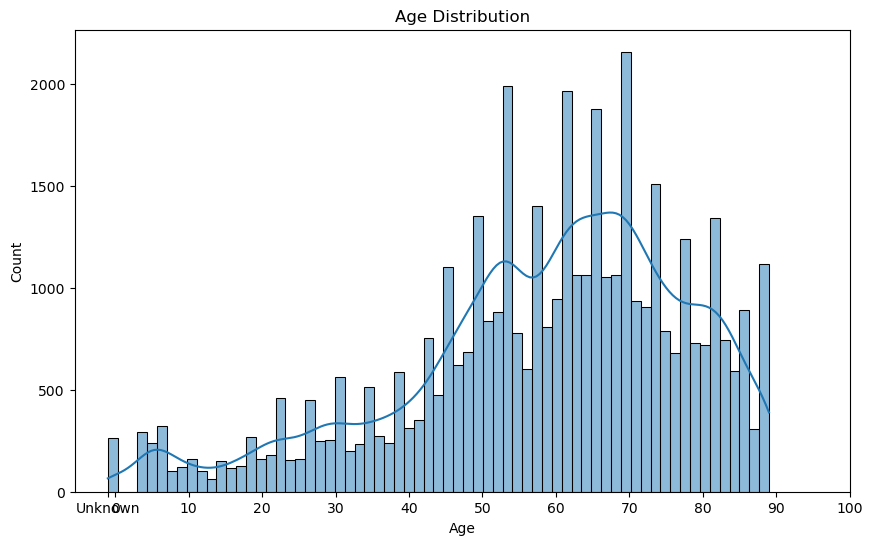

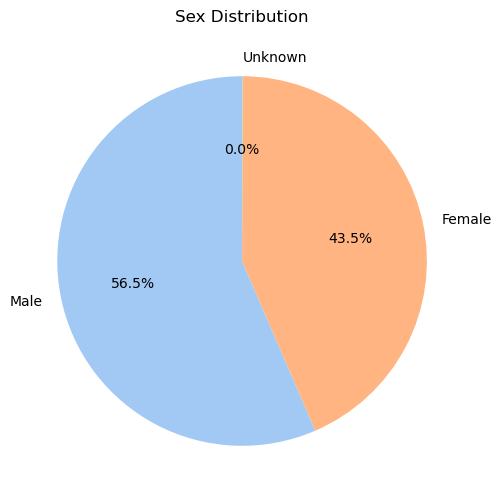

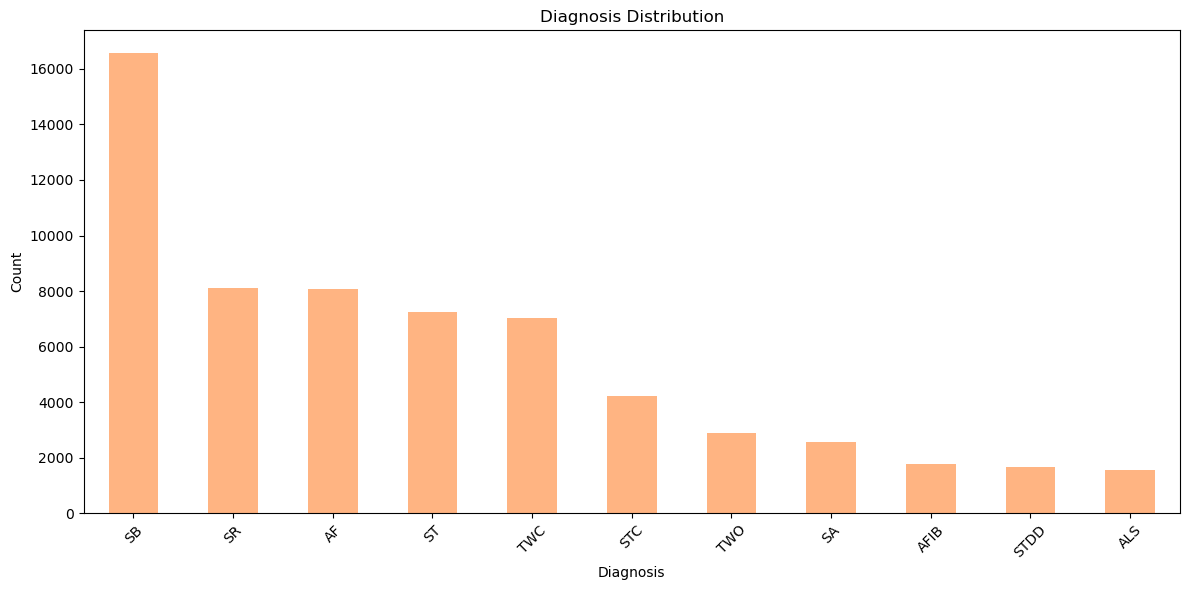

In [2]:
# Define a consistent color palette
COLOR_PALETTE = sns.color_palette("pastel")

def plot_age_distribution(clinical_data):
    try:
        clinical_data['Age'] = pd.to_numeric(clinical_data['Age'], errors='coerce')
        clinical_data['Age'] = clinical_data['Age'].fillna(-1)

        fig, ax = plt.subplots(figsize=(10, 6))
        sns.histplot(clinical_data['Age'], kde=True, ax=ax)#, color=COLOR_PALETTE[0])  # Use color from palette

        ax.set_title('Age Distribution')
        ax.set_xlabel('Age')
        ax.set_ylabel('Count')
        plt.xticks(ticks=[-1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                   labels=['Unknown', 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
        plt.savefig("Visualizations/age_distribution.svg", dpi=1200, bbox_inches="tight")  # Save the plot
        plt.show()
    except Exception as e:
        logging.error(f"Error plotting age distribution: {str(e)}")

def plot_sex_distribution(clinical_data):
    try:
        sex_counts = clinical_data['Sex'].value_counts()
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90, colors=COLOR_PALETTE)  # Use palette
        ax.set_title('Sex Distribution')
        plt.savefig("Visualizations/sex_distribution.svg", dpi=1200)  # Save the plot
        plt.show()
    except Exception as e:
        logging.error(f"Error plotting sex distribution: {str(e)}")

def plot_diagnosis_distribution(y, code_to_acronym):
    try:
        y_flat = [item for sublist in y for item in sublist]
        diagnosis_counts = pd.Series(y_flat).value_counts()
        diagnosis_counts = diagnosis_counts[diagnosis_counts.index.notnull()]
        diagnosis_counts.index = diagnosis_counts.index.map(code_to_acronym)
        plt.figure(figsize=(12, 6))
        diagnosis_counts.plot(kind='bar', color=COLOR_PALETTE[1])  # Use color from palette
        plt.title('Diagnosis Distribution')
        plt.xlabel('Diagnosis')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("Visualizations/diagnosis_distribution.svg", dpi=1200)  # Save the plot
        plt.show()
    except Exception as e:
        logging.error(f"Error plotting diagnosis distribution: {str(e)}")

def visualize_ecg(signals, diagnosis, age, sex, num_samples=1000):  # Add num_samples parameter
    try:
        fig, axs = plt.subplots(3, 4, figsize=(20, 15))
        fig.suptitle(f'ECG Signals - Diagnosis: {diagnosis}, Age: {age}, Sex: {sex}', fontsize=16)
        for i in range(12):
            row = i // 4
            col = i % 4
            axs[row, col].plot(signals[i, :num_samples], color=COLOR_PALETTE[i % len(COLOR_PALETTE)])  # Plot first num_samples
            axs[row, col].set_title(f'Lead {i+1}')
            axs[row, col].set_ylim(-5, 5)
        plt.tight_layout()
        # Save the plot in high resolution in svg format
        plt.savefig(f"Visualizations/ecg_visualization_{diagnosis}_{age}_{sex}.svg", dpi=1200)
        plt.savefig(f"Visualizations/ecg_visualization_{diagnosis}_{age}_{sex}.svg", dpi=1200) 
        plt.show()
    except Exception as e:
        logging.error(f"Error visualizing ECG: {str(e)}")

# Load the SNOMED CT mapping
snomed_ct_csv = "cvd-dataset/ConditionNames_SNOMED-CT.csv"
code_to_acronym, code_to_fullname = load_snomed_ct_mapping(snomed_ct_csv)

# Call visualization functions
plot_age_distribution(clinical_data.copy())  # Pass a copy to avoid modifying the original
plot_sex_distribution(clinical_data.copy())  # Pass a copy to avoid modifying the original
plot_diagnosis_distribution(y, code_to_acronym)

# Visualize some ECG signals
#for i in range(3):
#    visualize_ecg(X[i].reshape(12, -1), y[i], clinical_data.iloc[i]['Age'], clinical_data.iloc[i]['Sex'])

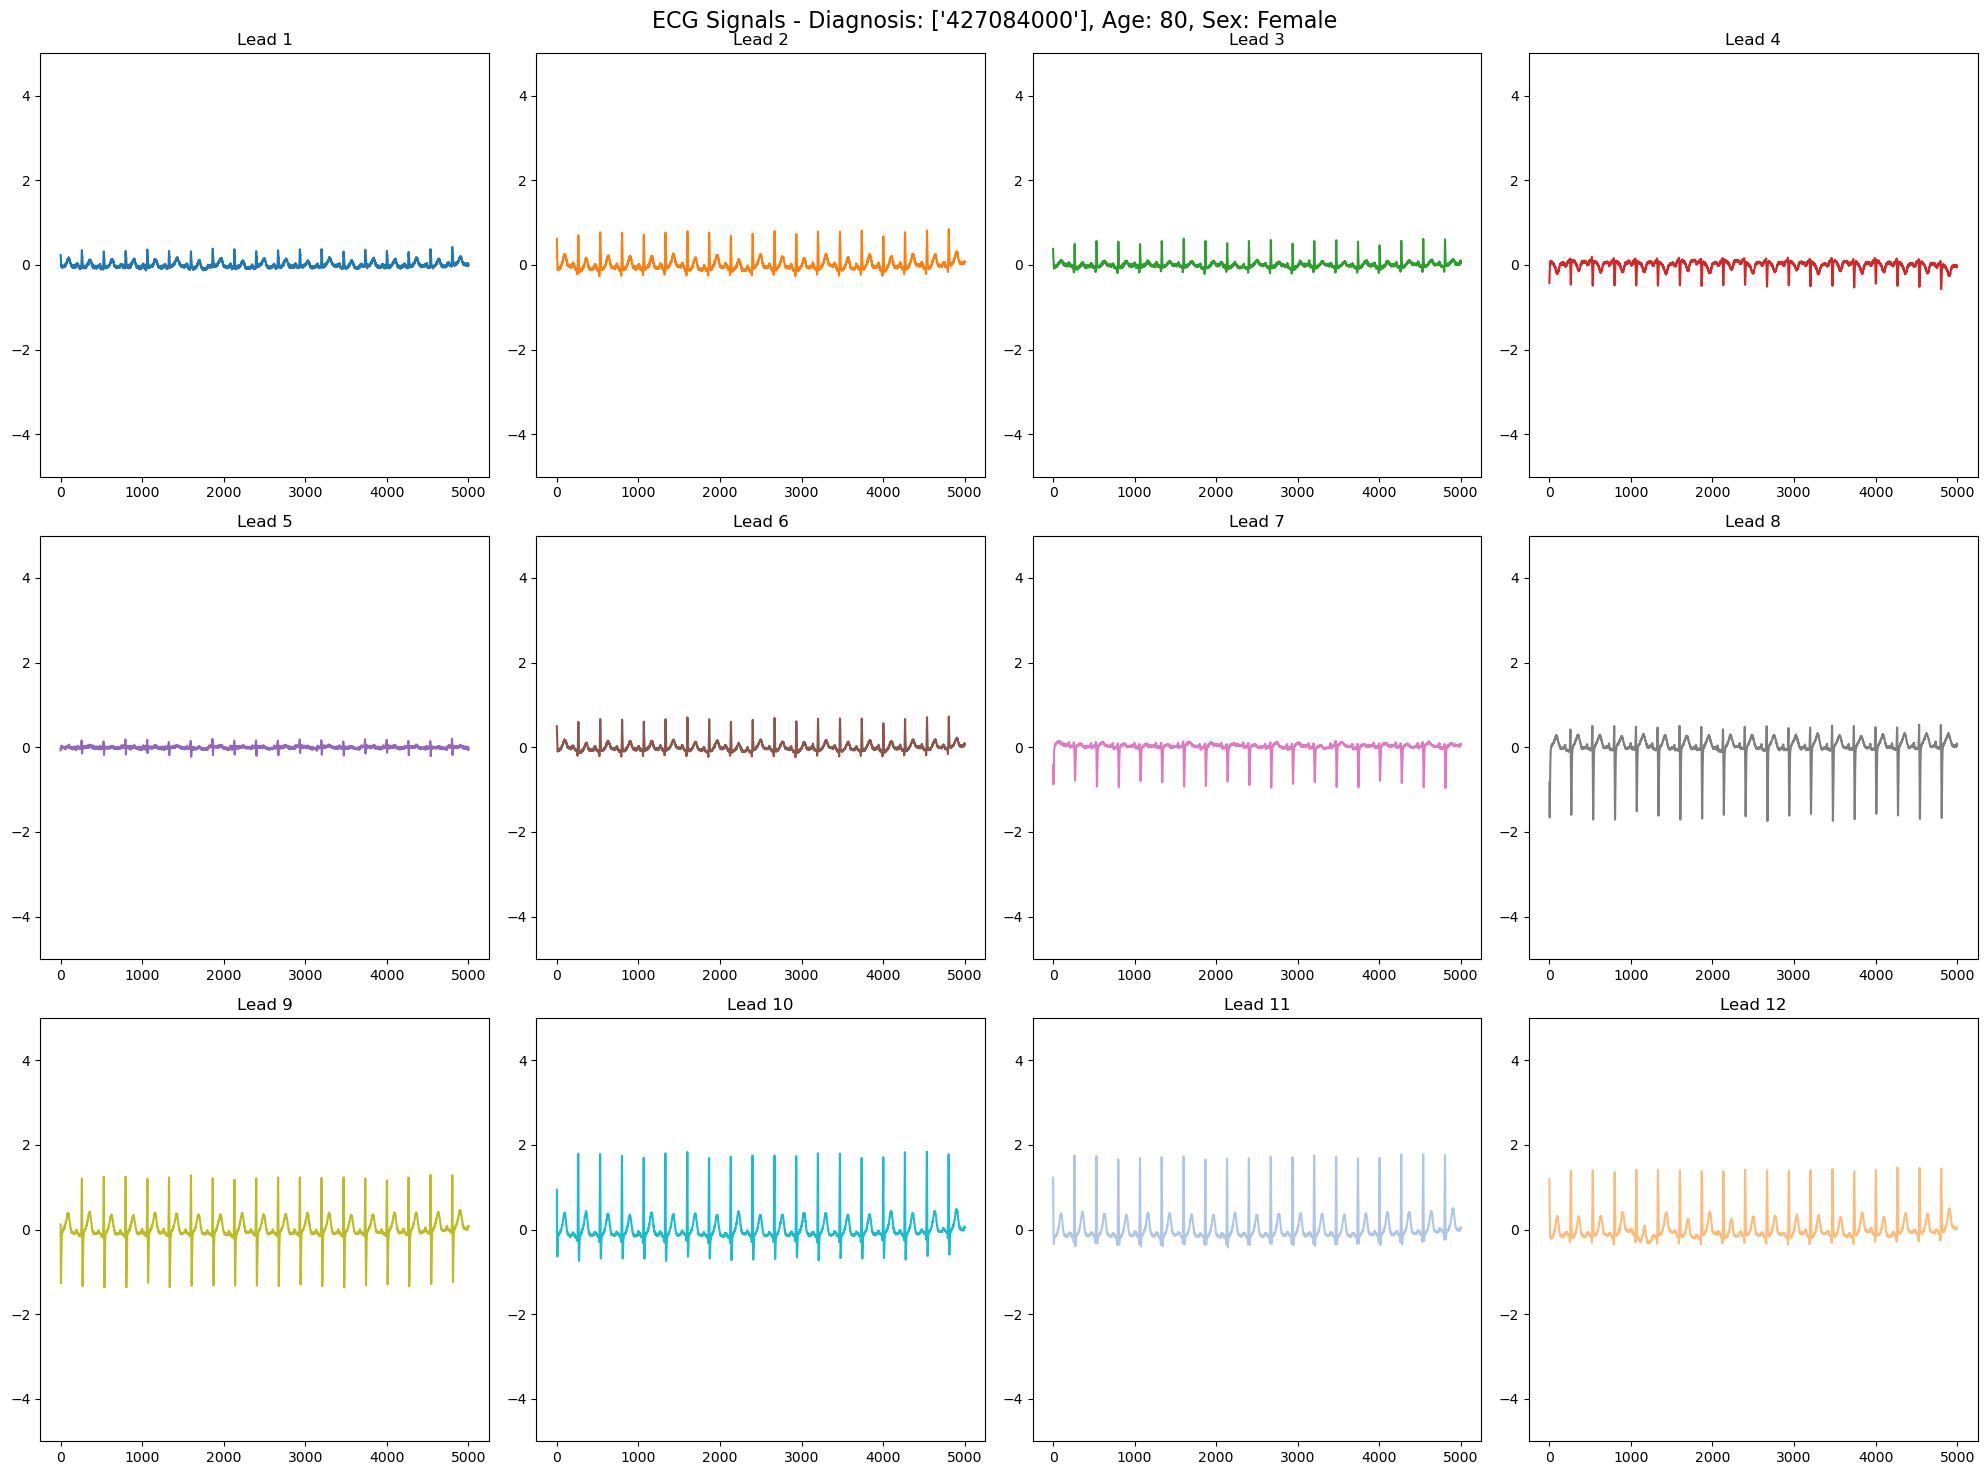

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import logging

def visualize_ecg(signals, diagnosis, age, sex, num_samples=5000):
    try:
        fig, axs = plt.subplots(3, 4, figsize=(20, 15))
        fig.suptitle(f'ECG Signals - Diagnosis: {diagnosis}, Age: {age}, Sex: {sex}', fontsize=16)
        
        for i in range(12):
            row = i // 4
            col = i % 4
            axs[row, col].plot(signals[i, :num_samples], color=COLOR_PALETTE[i % len(COLOR_PALETTE)])
            axs[row, col].set_title(f'Lead {i+1}')
            axs[row, col].set_ylim(-5, 5)
        
        plt.tight_layout()
        plt.savefig(f"Visualizations/ecg_visualization_{diagnosis}_{age}_{sex}.svg", dpi=1200)
        plt.show()
    except Exception as e:
        logging.error(f"Error visualizing ECG: {str(e)}")

# Visualize random ECG signals from the dataset
num_visualizations = 1
total_samples = len(X)

for _ in range(num_visualizations):
    # Randomly select an index
    random_index = np.random.randint(0, total_samples)
    
    # Get the corresponding data
    selected_signals = X[random_index].reshape(12, -1)
    selected_diagnosis = y[random_index]
    selected_age = clinical_data.iloc[random_index]['Age']
    selected_sex = clinical_data.iloc[random_index]['Sex']
    
    # Visualize the randomly selected ECG
    visualize_ecg(selected_signals, selected_diagnosis, selected_age, selected_sex)

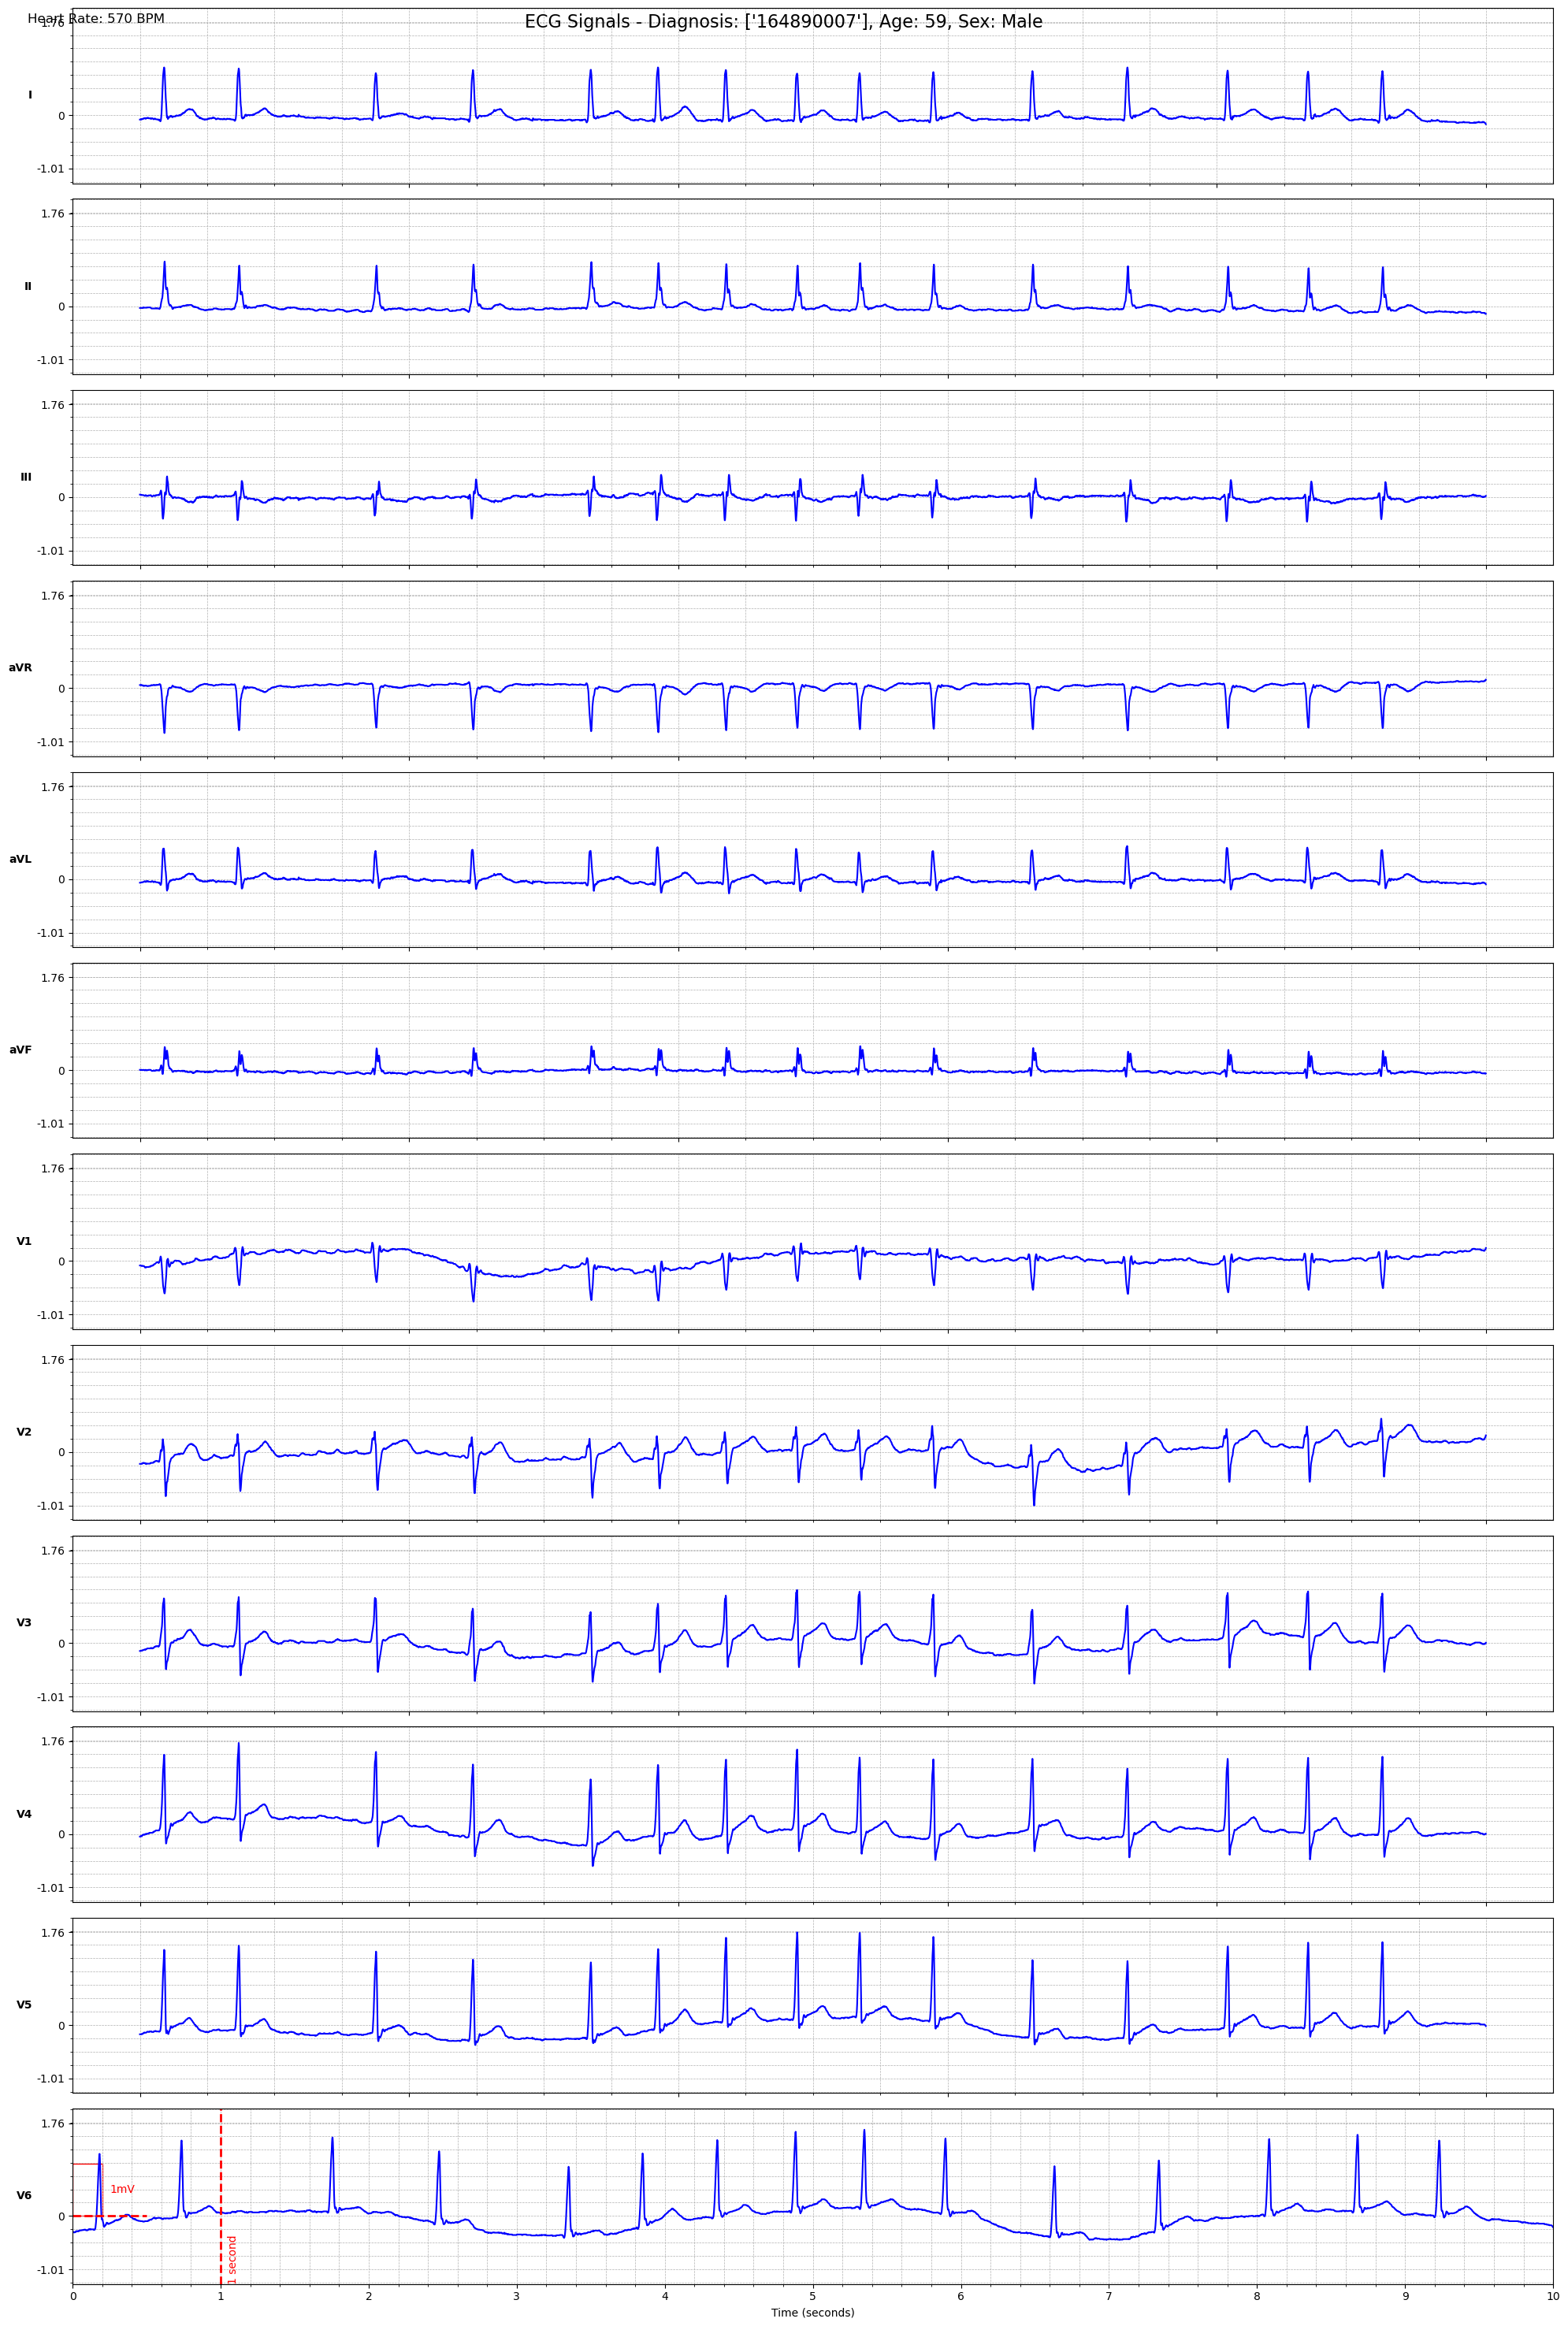

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator

def calculate_heart_rate(signals, sample_rate):
    lead_ii = signals[1] if signals.ndim == 2 else signals
    peaks = np.where((lead_ii[1:-1] > lead_ii[:-2]) & (lead_ii[1:-1] > lead_ii[2:]))[0] + 1
    if len(peaks) > 1:
        mean_rr_interval = np.mean(np.diff(peaks)) / sample_rate
        return 60 / mean_rr_interval
    return None

def visualize_ecg_enhanced_v7(signals, diagnosis, age, sex, sample_rate=500, num_samples=5000):
    try:
        # Reshape the signals if it's a 1D array
        if signals.ndim == 1:
            signals = signals.reshape(12, -1)
        
        fig = plt.figure(figsize=(20, 30))
        gs = gridspec.GridSpec(12, 1, height_ratios=[1]*12)
        fig.suptitle(f'ECG Signals - Diagnosis: {diagnosis}, Age: {age}, Sex: {sex}', fontsize=16)

        time = np.arange(num_samples) / sample_rate
        lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

        # Calculate global min and max
        global_min = np.min(signals)
        global_max = np.max(signals)
        y_range = global_max - global_min
        y_margin = y_range * 0.1  # 10% margin

        for i in range(12):
            ax = fig.add_subplot(gs[i])
            signal = signals[i, :num_samples]
            
            ax.plot(time, signal, color='blue')
            ax.set_ylabel(lead_names[i], rotation=0, ha='right', va='center', fontweight='bold')
            
            if i < 11:
                ax.set_xticklabels([])
            
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            ax.minorticks_on()
            
            # Set y-axis limits based on global min and max
            ax.set_ylim(global_min - y_margin, global_max + y_margin)
            
            # Add y-axis ticks
            ax.set_yticks([global_min, 0, global_max])
            ax.set_yticklabels([f'{global_min:.2f}', '0', f'{global_max:.2f}'])

        # Set x-axis for the full 10 seconds
        ax.set_xlim(0, 10)
        ax.set_xlabel('Time (seconds)')
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax.xaxis.set_major_locator(plt.MultipleLocator(1))

        # Add 1 second reference line
        ax.axvline(x=1, color='r', linestyle='--', linewidth=2)
        ax.text(1.05, global_min - y_margin, '1 second', color='r', rotation=90, va='bottom')
        
        # Add 1mV reference line
        mV_height = 1.0  # 1 mV
        ax.axhline(y=0, color='r', linestyle='--', linewidth=2, xmax=0.05)
        ax.add_patch(plt.Rectangle((0, 0), 0.2, mV_height, fill=False, color='r'))
        ax.text(0.25, mV_height/2, '1mV', color='r', ha='left', va='center')

        heart_rate = calculate_heart_rate(signals, sample_rate)
        if heart_rate:
            fig.text(0.02, 0.98, f'Heart Rate: {heart_rate:.0f} BPM', fontsize=12, va='top')

        plt.tight_layout()
        plt.savefig(f"Visualizations/ecg_visualization_enhanced_v7_{diagnosis}_{age}_{sex}.svg", dpi=1200)
        plt.show()
    except Exception as e:
        print(f"Error visualizing ECG: {str(e)}")

# Usage:
# Assuming X is your dataset with shape (num_patients, 60000) where 60000 = 12 leads * 5000 samples
# and y, clinical_data are defined as before

num_visualizations = 1
total_samples = len(X)

for _ in range(num_visualizations):
    random_index = np.random.randint(0, total_samples)
    selected_signals = X[random_index]
    selected_diagnosis = y[random_index]
    selected_age = clinical_data.iloc[random_index]['Age']
    selected_sex = clinical_data.iloc[random_index]['Sex']
    
    visualize_ecg_enhanced_v7(selected_signals, selected_diagnosis, selected_age, selected_sex)

In [86]:
# Count of Unknown values in Age column
print(clinical_data['Age'].value_counts()['Unknown'])

# Count of Unknown values in Sex column
print(clinical_data['Sex'].value_counts()['Unknown'])

50
20


In [87]:
# Print number of Unknown in Age column
print('Number of Unknown Age records column is:',clinical_data['Age'].value_counts()['Unknown'])

# Print number of Unknown in Sex column
print('\nNumber of Unknown Sex records column is:',clinical_data['Sex'].value_counts()['Unknown'])

y_flat = [item for sublist in y for item in sublist]
diagnosis_counts = pd.Series(y_flat).value_counts()
diagnosis_counts = diagnosis_counts[diagnosis_counts.index.notnull()]
diagnosis_counts.index = diagnosis_counts.index.map(code_to_acronym)

print("\nTop 15 Diagnosis:\n",diagnosis_counts.head(11))

Number of Unknown Age records column is: 50

Number of Unknown Sex records column is: 20

Top 15 Diagnosis:
 SB      16559
SR       8125
AF       8060
ST       7254
TWC      7043
STC      4232
TWO      2877
SA       2550
AFIB     1780
STDD     1668
ALS      1545
Name: count, dtype: int64


## Addressing Class Imbalance

### Combine and Flatten Data for Resampling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from sklearn.impute import SimpleImputer
from collections import Counter
from tqdm import tqdm
import pickle
import logging
import imblearn

# Flatten the data for resampling
X_flat = [signal.flatten() for signal in X]
y_flat = [label[0] for label in y]  # Assuming each entry in y is a list of labels, take the first label for simplicity

# Convert to numpy arrays
X_flat = np.array(X_flat)
y_flat = np.array(y_flat)


### Handle NaN Values

In [ ]:
# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_flat = imputer.fit_transform(X_flat)


### Apply SMOTE and ENN in Chunks with Manual Progress Updates

In [7]:
# Function to apply SMOTE in chunks with dynamic adjustment of k_neighbors parameter
def smote_resample(X, y, chunk_size=5000):
    X_resampled = []
    y_resampled = []
    pbar = tqdm(total=len(X), desc="Applying SMOTE", unit="sample")

    for start in range(0, len(X), chunk_size):
        end = min(start + chunk_size, len(X))
        X_chunk, y_chunk = X[start:end], y[start:end]
        
        # Find the minimum class size in the chunk
        min_class_size = min([sum(y_chunk == cls) for cls in np.unique(y_chunk)])
        
        # Adjust k_neighbors dynamically based on the minimum class size
        k_neighbors = min(3, min_class_size - 1) if min_class_size > 1 else 1
        
        if k_neighbors > 1:  # Only apply SMOTE if there are enough samples
            smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
            X_chunk_resampled, y_chunk_resampled = smote.fit_resample(X_chunk, y_chunk)
            X_resampled.append(X_chunk_resampled)
            y_resampled.append(y_chunk_resampled)
        else:
            X_resampled.append(X_chunk)
            y_resampled.append(y_chunk)
        
        pbar.update(end - start)
    
    pbar.close()
    return np.vstack(X_resampled), np.hstack(y_resampled)

# Function to apply RENN in chunks
def renn_resample(X, y, chunk_size=5000):
    renn = RepeatedEditedNearestNeighbours()
    X_resampled = []
    y_resampled = []
    pbar = tqdm(total=len(X), desc="Applying RENN", unit="sample")
    
    for start in range(0, len(X), chunk_size):
        end = min(start + chunk_size, len(X))
        X_chunk, y_chunk = renn.fit_resample(X[start:end], y[start:end])
        X_resampled.append(X_chunk)
        y_resampled.append(y_chunk)
        pbar.update(end - start)
    
    pbar.close()
    return np.vstack(X_resampled), np.hstack(y_resampled)

# Apply SMOTE
X_smote_resampled, y_smote_resampled = smote_resample(X_flat, y_flat, chunk_size=5000)

# Apply RENN
X_resampled, y_resampled = renn_resample(X_smote_resampled, y_smote_resampled, chunk_size=5000)

# Save the resampled data to files
np.save("X_resampled.npy", X_resampled)
with open("y_resampled.pkl", "wb") as f:
    pickle.dump(y_resampled, f)

# Save clinical data as well
clinical_data.to_csv("clinical_data_processed.csv", index=False)





Applying SMOTE:   0%|          | 0/43703 [00:00<?, ?sample/s]


Applying SMOTE:  11%|█▏        | 5000/43703 [00:13<01:44, 369.44sample/s]


Applying SMOTE:  46%|████▌     | 20000/43703 [00:23<00:24, 953.07sample/s]


Applying SMOTE:  57%|█████▋    | 25000/43703 [00:33<00:24, 755.04sample/s]


Applying SMOTE:  57%|█████▋    | 25000/43703 [00:46<00:24, 755.04sample/s]


Applying SMOTE: 100%|██████████| 43703/43703 [00:47<00:00, 926.20sample/s]



Applying RENN:   0%|          | 0/117660 [00:00<?, ?sample/s]


Applying RENN:   4%|▍         | 5000/117660 [00:05<02:07, 883.75sample/s]


Applying RENN:   8%|▊         | 10000/117660 [00:10<01:45, 1020.12sample/s]


Applying RENN:  13%|█▎        | 15000/117660 [00:15<01:41, 1011.02sample/s]


Applying RENN:  17%|█▋        | 20000/117660 [00:25<02:20, 692.68sample/s] 


Applying RENN:  21%|██        | 25000/117660 [00:30<01:59, 778.26sample/s]


Applying RENN:  25%|██▌       | 30000/117660 [00:36<01:47, 819.20sample/s]


Applying RENN:  30%|

### Load the Resampled Data

In [ ]:
import numpy as np
import pandas as pd
import pickle

# Load the resampled data
X_resampled = np.load("X_resampled.npy")
with open("y_resampled.pkl", "rb") as f:
    y_resampled = pickle.load(f)

In [ ]:
y_resampled = [item for sublist in y_resampled for item in sublist]

### Visualize the Class Distribution After Resampling

2024-07-15 03:20:44,203 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-15 03:20:44,205 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


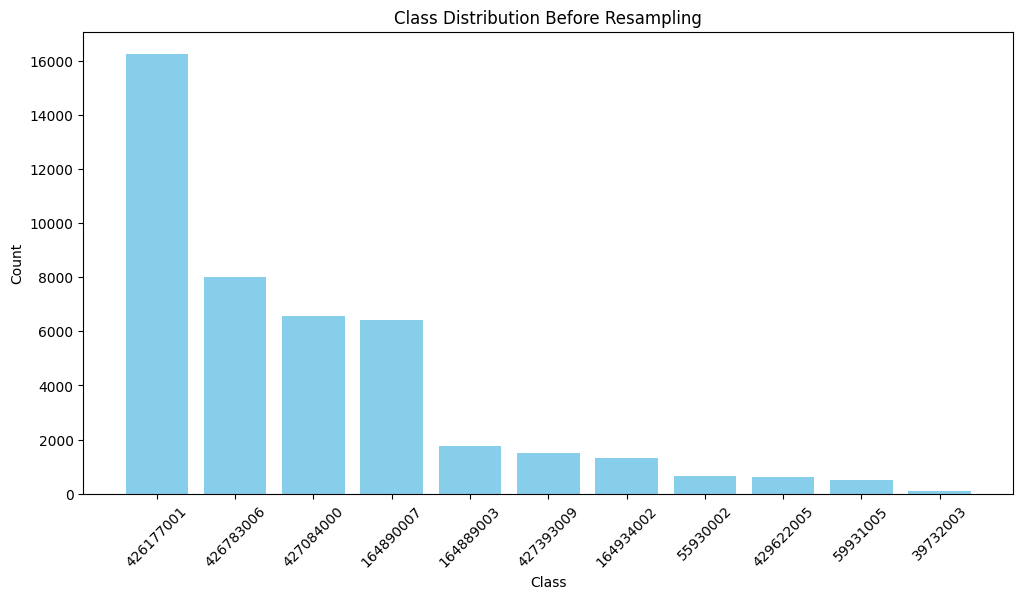

2024-07-15 03:20:44,723 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-07-15 03:20:44,724 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


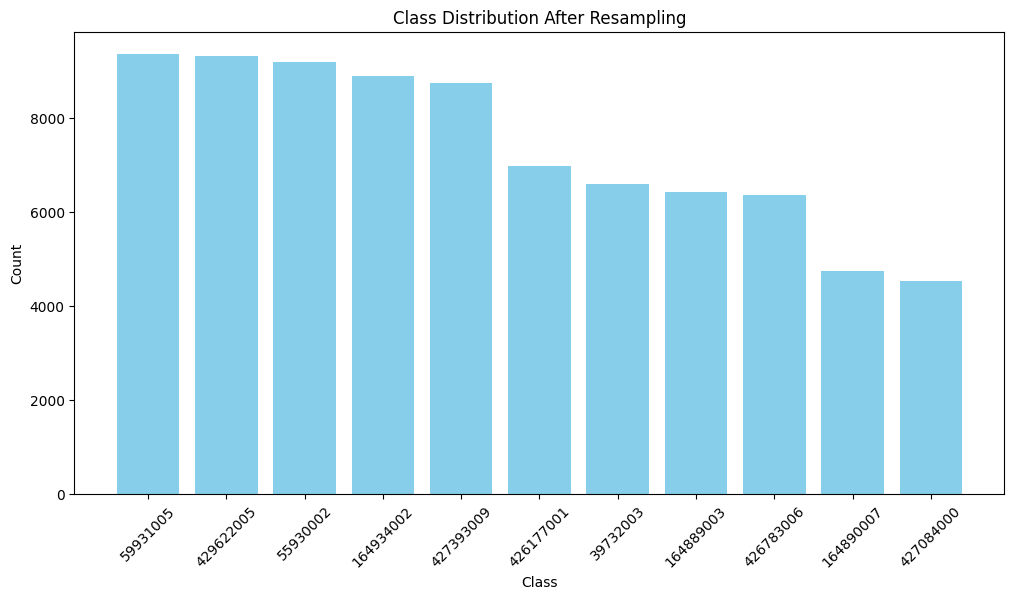

In [8]:
# Visualize class distribution before and after resampling
def plot_class_distribution(y, title):
    counter = Counter(y)
    df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
    df.columns = ['Class', 'Count']
    df = df.sort_values(by='Count', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.bar(df['Class'], df['Count'], color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Plot before resampling
plot_class_distribution(y_flat, 'Class Distribution Before Resampling')

# Plot after resampling
plot_class_distribution(y_resampled, 'Class Distribution After Resampling')


### Load the Resampled Data

In [ ]:
import numpy as np
import pandas as pd
import pickle

# Load resampled data
X_resampled = np.load("X_resampled.npy", allow_pickle=True)
with open("y_resampled.pkl", "rb") as f:
    y_resampled = pickle.load(f)
clinical_data = pd.read_csv("clinical_data.csv")


### Resampled Clinical Data

In [2]:
# Check the shape of resampled data
print(f"Shape of X_resampled: {X_resampled.shape}")
print(f"Shape of y_resampled: {len(y_resampled)}")

# Number of resampled records
num_resampled_records = X_resampled.shape[0]

# Ensure clinical_data matches resampled data
resampled_indices = np.random.choice(clinical_data.index, size=num_resampled_records, replace=True)
clinical_data_resampled = clinical_data.iloc[resampled_indices]

# Ensure that clinical_data_resampled has the same length as X_resampled and y_resampled
assert len(clinical_data_resampled) == len(X_resampled) == len(y_resampled)

# Save the resampled clinical data
clinical_data_resampled.to_csv("clinical_data_resampled.csv", index=False)


Shape of X_resampled: (81213, 60000)
Shape of y_resampled: 81213


In [3]:
# Verify the shapes
print(f"Shape of X_resampled: {X_resampled.shape}")
print(f"Shape of y_resampled: {len(y_resampled)}")
print(f"Shape of clinical_data_resampled: {clinical_data_resampled.shape}")

# Print the first few rows of clinical_data_resampled
print(clinical_data_resampled.head())


Shape of X_resampled: (81213, 60000)
Shape of y_resampled: 81213
Shape of clinical_data_resampled: (81213, 5)
      Age     Sex              SNOMED_CT_Codes Diagnoses_Acronyms  \
42470  54    Male  164890007,55827005,55930002         AF,LVH,STC   
29169  29    Male                    426177001                 SB   
12388  75  Female          164890007,164934002             AF,TWC   
2654   71  Female                    426177001                 SB   
37426  81    Male           164890007,10370003              AF,PR   

                                     Diagnoses_Fullnames  
42470  Atrial Flutter,left ventricle hypertrophy,ST s...  
29169                                  Sinus Bradycardia  
12388                       Atrial Flutter,T wave Change  
2654                                   Sinus Bradycardia  
37426       Atrial Flutter,Rhythm from artificial pacing  


## ECG Normalization

### Load the Resampled Data

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

# Load resampled data using memory mapping for efficiency
def load_numpy_efficiently(filename):
    return np.load(filename, mmap_mode='r')

# Load the resampled data
X_resampled = load_numpy_efficiently("X_resampled.npy")

# Load y_resampled
with open("y_resampled.pkl", "rb") as f:
    y_resampled = pickle.load(f)

# Load clinical data
clinical_data_resampled = pd.read_csv("clinical_data_resampled.csv")

print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", len(y_resampled))
print("Shape of clinical_data_resampled:", clinical_data_resampled.shape)


Shape of X_resampled: (81213, 60000)
Shape of y_resampled: 81213
Shape of clinical_data_resampled: (81213, 5)


### Normalizing the Data

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle

# Load resampled data using memory mapping for efficiency
def load_numpy_efficiently(filename):
    return np.load(filename, mmap_mode='r')

# Load the resampled data
X_resampled = load_numpy_efficiently("X_resampled.npy")

# Initialize the scaler and progress bar
scaler = StandardScaler()
pbar = tqdm(total=X_resampled.shape[0], desc="Normalizing data", unit="sample")

# Normalize ECG signals in chunks
batch_size = 1000  # Define the chunk size
X_resampled_normalized = np.zeros_like(X_resampled)

for start in range(0, X_resampled.shape[0], batch_size):
    end = min(start + batch_size, X_resampled.shape[0])
    X_resampled_normalized[start:end] = scaler.fit_transform(X_resampled[start:end])
    pbar.update(end - start)

pbar.close()

# Save the normalized data
np.save("X_resampled_normalized.npy", X_resampled_normalized)

# Save the scaler for future use
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


Normalizing data: 100%|██████████| 81213/81213 [01:44<00:00, 778.81sample/s] 


### Feature Engineering

In [4]:
import pandas as pd

# Load clinical data
clinical_data_resampled = pd.read_csv("clinical_data_resampled.csv")

# Create a copy of the DataFrame to avoid chained assignment warnings
clinical_data_resampled = clinical_data_resampled.copy()

# Encode categorical variables
clinical_data_resampled['Age'] = pd.to_numeric(clinical_data_resampled['Age'], errors='coerce')
clinical_data_resampled['Age'] = clinical_data_resampled['Age'].fillna(-1)  # Use -1 for unknown age
clinical_data_resampled['Sex'] = clinical_data_resampled['Sex'].fillna('Unknown')

# One-hot encoding for gender
clinical_data_resampled_encoded = pd.get_dummies(clinical_data_resampled, columns=['Sex'], drop_first=False)
clinical_data_resampled_encoded.to_csv("clinical_data_resampled_encoded.csv", index=False)


### Data Splitting

In [5]:
from sklearn.model_selection import train_test_split
import pickle

# Load the normalized ECG signals and resampled clinical data
X_resampled_normalized = np.load("X_resampled_normalized.npy", allow_pickle=True)
clinical_data_resampled_encoded = pd.read_csv("clinical_data_resampled_encoded.csv")

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled_normalized, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Split clinical data correspondingly
clinical_train = clinical_data_resampled_encoded.iloc[:len(X_train)]
clinical_temp = clinical_data_resampled_encoded.iloc[len(X_train):]
clinical_val = clinical_temp.iloc[:len(X_val)]
clinical_test = clinical_temp.iloc[len(X_val):]

# Save the split data
np.save("X_train.npy", X_train)
np.save("X_val.npy", X_val)
np.save("X_test.npy", X_test)
with open("y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)
with open("y_val.pkl", "wb") as f:
    pickle.dump(y_val, f)
with open("y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)
clinical_train.to_csv("clinical_train.csv", index=False)
clinical_val.to_csv("clinical_val.csv", index=False)
clinical_test.to_csv("clinical_test.csv", index=False)


## Model Building and Training with Checkpointing

### Load the Data

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle

# Function to load numpy arrays with progress bar
def load_numpy_with_progress(filename):
    data = np.load(filename, mmap_mode='r')
    shape = data.shape
    loaded_data = np.zeros(shape, dtype=np.float32)
    pbar = tqdm(total=shape[0], desc=f"Loading {filename}", unit="sample")

    for i in range(shape[0]):
        loaded_data[i] = data[i]
        pbar.update(1)

    pbar.close()
    return loaded_data

# Load the data with progress bars
X_train = load_numpy_with_progress("X_train.npy")
X_val = load_numpy_with_progress("X_val.npy")
X_test = load_numpy_with_progress("X_test.npy")

def load_pickle_with_progress(filename, description):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    pbar = tqdm(total=len(data), desc=description, unit="item")
    for i in range(len(data)):
        pbar.update(1)
    pbar.close()
    return data

# Load y data with progress bars and convert to integers
y_train = load_pickle_with_progress("y_train.pkl", "Loading y_train")
y_val = load_pickle_with_progress("y_val.pkl", "Loading y_val")
y_test = load_pickle_with_progress("y_test.pkl", "Loading y_test")

# Convert y data to int
y_train = np.array(y_train).astype(int)
y_val = np.array(y_val).astype(int)
y_test = np.array(y_test).astype(int)

# Load clinical data
def load_csv_with_progress(filename):
    data = pd.read_csv(filename)
    pbar = tqdm(total=len(data), desc=f"Loading {filename}", unit="row")
    for _ in range(len(data)):
        pbar.update(1)
    pbar.close()
    return data

clinical_train = load_csv_with_progress("clinical_train.csv")
clinical_val = load_csv_with_progress("clinical_val.csv")
clinical_test = load_csv_with_progress("clinical_test.csv")

# Convert clinical data to numpy arrays and ensure correct dtype
age_train = clinical_train['Age'].values.astype(np.float32)
age_val = clinical_val['Age'].values.astype(np.float32)
age_test = clinical_test['Age'].values.astype(np.float32)

sex_train = clinical_train[['Sex_Female', 'Sex_Male', 'Sex_Unknown']].values.astype(np.float32)
sex_val = clinical_val[['Sex_Female', 'Sex_Male', 'Sex_Unknown']].values.astype(np.float32)
sex_test = clinical_test[['Sex_Female', 'Sex_Male', 'Sex_Unknown']].values.astype(np.float32)

# Print data types and shapes
print("X_train dtype:", X_train.dtype, "shape:", X_train.shape)
print("age_train dtype:", age_train.dtype, "shape:", age_train.shape)
print("sex_train dtype:", sex_train.dtype, "shape:", sex_train.shape)
print("y_train dtype:", y_train.dtype, "shape:", y_train.shape)

print("X_val dtype:", X_val.dtype, "shape:", X_val.shape)
print("age_val dtype:", age_val.dtype, "shape:", age_val.shape)
print("sex_val dtype:", sex_val.dtype, "shape:", sex_val.shape)
print("y_val dtype:", y_val.dtype, "shape:", y_val.shape)

Loading clinical_test.csv: 100%|██████████| 12182/12182 [00:00<00:00, 4510107.81row/s]

X_train dtype: float32 shape: (56849, 60000)
age_train dtype: float32 shape: (56849,)
sex_train dtype: float32 shape: (56849, 3)
y_train dtype: int64 shape: (56849,)
X_val dtype: float32 shape: (12182, 60000)
age_val dtype: float32 shape: (12182,)
sex_val dtype: float32 shape: (12182, 3)
y_val dtype: int64 shape: (12182,)


### Visualizing the Distribution after resampling, preprocessing and splitting

{270492004: '1AVB', 195042002: '2AVB', 54016002: '2AVB1', 28189009: '2AVB2', 27885002: '3AVB', 251173003: 'ABI', 39732003: 'ALS', 284470004: 'APB', 164917005: 'AQW', 47665007: 'ARS', 233917008: 'AVB', 251199005: 'CCR', 251198002: 'CR', 428417006: 'ERV', 164942001: 'FQRS', 698252002: 'IVB', 426995002: 'JEB', 251164006: 'JPT', 164909002: 'LFBBB', 55827005: 'LVH', 251146004: 'LVQRSAL', 251148003: 'LVQRSCL', 251147008: 'LVQRSLL', 164865005: 'MISW', 164947007: 'PRIE', 164912004: 'PWC', 111975006: 'QTIE', 446358003: 'RAH', 59118001: 'RBBB', 713427006: 'CRBBB', 89792004: 'RVH', 429622005: 'STDD', 164930006: 'STE', 428750005: 'STTC', 164931005: 'STTU', 164934002: 'TWC', 59931005: 'TWO', 164937009: 'UW', 11157007: 'VB', 75532003: 'VEB', 13640000: 'VFW', 17338001: 'VPB', 195060002: 'VPE', 251180001: 'VET', 195101003: 'SAAWR', 74390002: 'WPW', 426177001: 'SB', 426783006: 'SR', 164889003: 'AFIB', 427084000: 'ST', 164890007: 'AF', 427393009: 'SA', 426761007: 'SVT', 713422000: 'AT', 233896004: 'AVNR

/var/tmp/ipykernel_27697/3183114841.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)  # Rotate x-axis labels


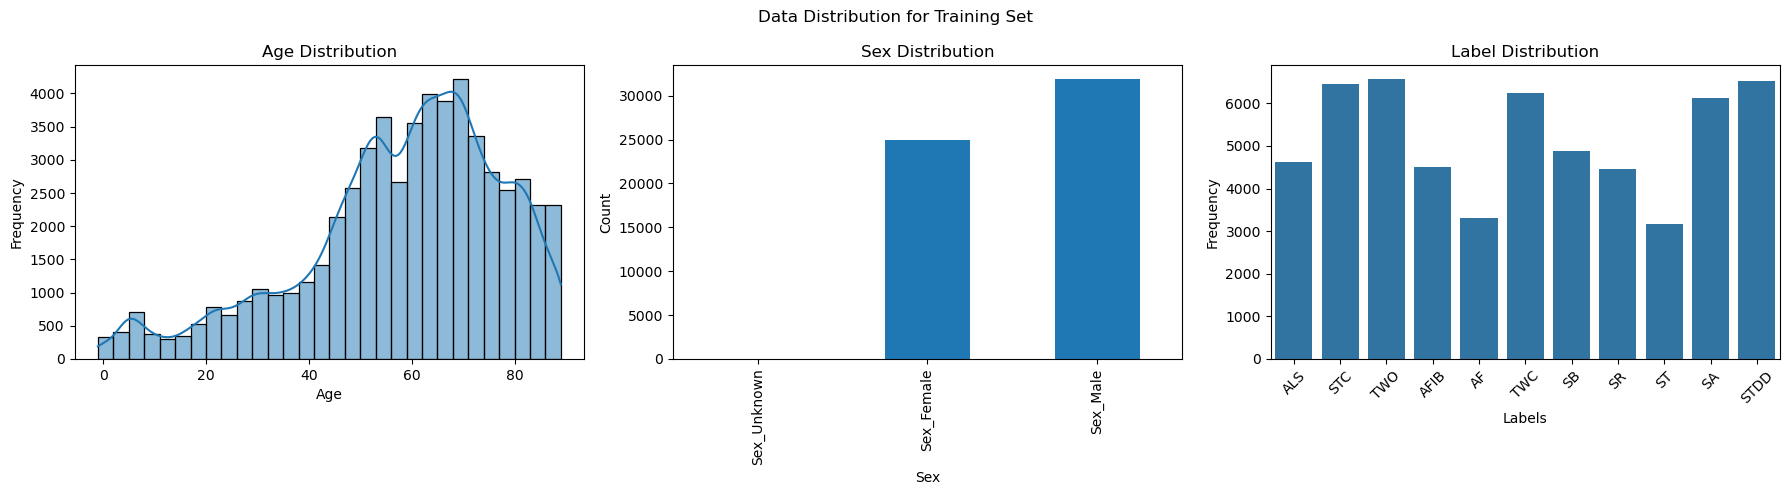

/var/tmp/ipykernel_27697/3183114841.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)  # Rotate x-axis labels


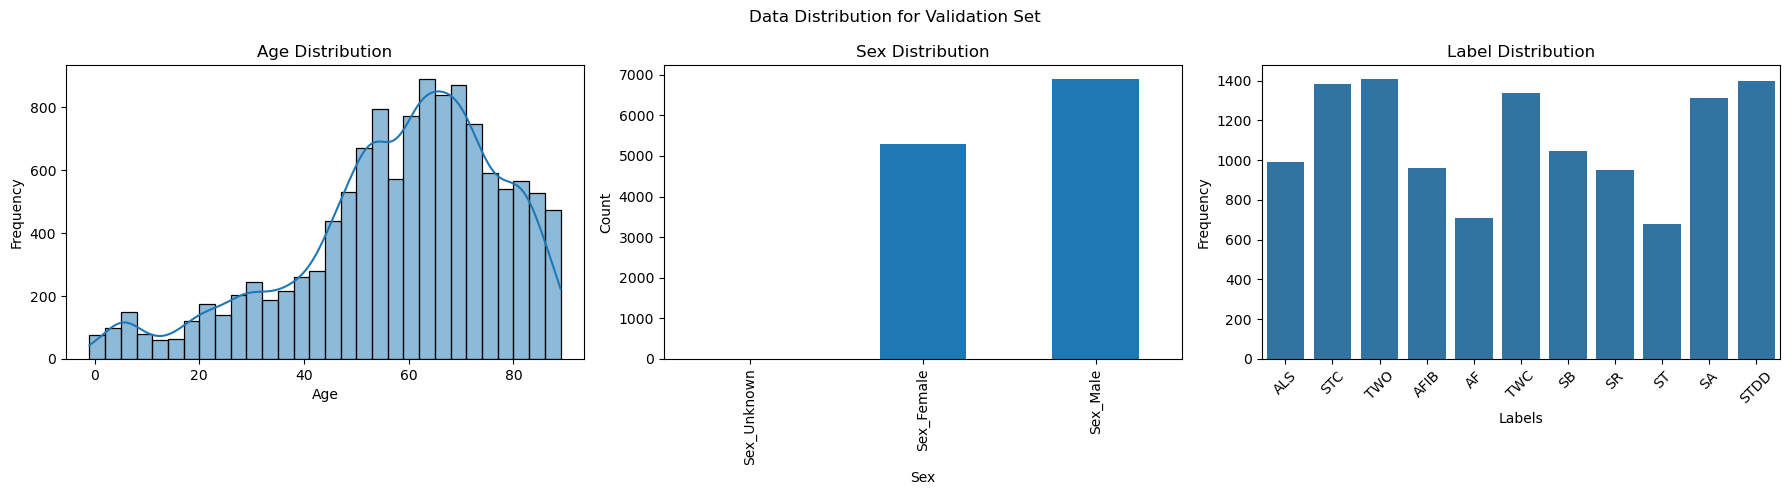

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# Load the CSV file containing the mapping from label codes to acronyms
condition_names_df = pd.read_csv('ConditionNames_SNOMED-CT-Copy1.csv')

# Create a mapping dictionary
code_to_acronym = pd.Series(condition_names_df.Acronym_Name.values, index=condition_names_df.Snomed_CT).to_dict()

# Example print to verify the mapping dictionary
print(code_to_acronym)


# Function to plot distributions with x-axis labels rotated and save the plots
def plot_distributions(age_data, sex_data, y_data, dataset_name, label_mapping):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Data Distribution for {dataset_name} Set')

    # Age distribution
    sns.histplot(age_data, bins=30, ax=axes[0], kde=True)
    axes[0].set_title('Age Distribution')
    axes[0].set_xlabel('Age')
    axes[0].set_ylabel('Frequency')

    # Sex distribution
    sex_df = pd.DataFrame(sex_data, columns=['Sex_Female', 'Sex_Male', 'Sex_Unknown'])
    sex_counts = sex_df.sum().sort_values()
    sex_counts.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Sex Distribution')
    axes[1].set_xlabel('Sex')
    axes[1].set_ylabel('Count')

    # Label distribution
    label_counts = pd.Series(y_data).value_counts().sort_index()
    labels = [label_mapping.get(code, code) for code in label_counts.index]
    sns.barplot(x=labels, y=label_counts.values, ax=axes[2])
    axes[2].set_title('Label Distribution')
    axes[2].set_xlabel('Labels')
    axes[2].set_ylabel('Frequency')
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)  # Rotate x-axis labels

    # Save the figure
    plt.tight_layout()
    plt.savefig(f'{dataset_name}_data_distribution.svg', dpi=1200)
    plt.show()

# Assuming the sex data is loaded as per your description
sex_train_df = pd.DataFrame(sex_train, columns=['Sex_Female', 'Sex_Male', 'Sex_Unknown'])
sex_val_df = pd.DataFrame(sex_val, columns=['Sex_Female', 'Sex_Male', 'Sex_Unknown'])

# Plot and save distributions for the training data
plot_distributions(age_train, sex_train_df, y_train, 'Training', code_to_acronym)

# Plot and save distributions for the validation data
plot_distributions(age_val, sex_val_df, y_val, 'Validation', code_to_acronym)
